# Binary Classification: Expenditure Churn Prediction

## Load the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_excel("./Expenditure-churn (3).xlsx")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       10000 non-null  int64  
 1   gender    10000 non-null  int64  
 2   marital   10000 non-null  float64
 3   dep       10000 non-null  int64  
 4   Income    10000 non-null  float64
 5   Job yrs   10000 non-null  int64  
 6   Town yrs  10000 non-null  int64  
 7   Yrs Ed    10000 non-null  int64  
 8   Dri Lic   10000 non-null  int64  
 9   Own Home  10000 non-null  int64  
 10  # Cred C  10000 non-null  int64  
 11  Churn     10000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 937.6 KB


## Use a Pipeline to preprocess and fit binary classification models

In [3]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features from target
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Standardise the whole dataset
std_scaler = StandardScaler().fit(X_train)

def preprocessor(X):
    D = np.copy(X)
    D = std_scaler.transform(D)
    return D

In [4]:
preprocess_transformer = FunctionTransformer(preprocessor)
preprocess_transformer

FunctionTransformer(func=<function preprocessor at 0x00000224D1DDADC8>)

### Fit a LogisticRegression() model

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

p1 = Pipeline([('scaler', preprocess_transformer),
              ('Logistic Regression', LogisticRegression())])
p1

Pipeline(steps=[('scaler',
                 FunctionTransformer(func=<function preprocessor at 0x00000224D1DDADC8>)),
                ('Logistic Regression', LogisticRegression())])

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score

def fit_and_print(p, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    # Fit the transformer
    p.fit(X_train, y_train)
    # Predict the train and test outputs
    test_prediction =p.predict(X_test)
    
    # Print the errors
    print("Accuracy Score:   "+str(accuracy_score(test_prediction, y_test)*100))
    print("Precision Score:  "+str(precision_score(test_prediction, y_test)*100))
    print("Recall Score:     "+str(recall_score(test_prediction, y_test)*100))
    print("roc_auc_score:    "+str(accuracy_score(test_prediction, y_test)*100))
    print("\nConfusion Matrix:\n", confusion_matrix(test_prediction, y_test))

In [7]:
fit_and_print(p1)

Accuracy Score:   99.44
Precision Score:  98.21656050955414
Recall Score:     100.0
roc_auc_score:    99.44

Confusion Matrix:
 [[1715   14]
 [   0  771]]


### Fit a RandomForestClassifier()

In [8]:
from sklearn.ensemble import RandomForestClassifier
p2 = Pipeline([('scaler', preprocess_transformer),
              ('RFC', RandomForestClassifier())])
fit_and_print(p2)

Accuracy Score:   99.2
Precision Score:  98.59872611464968
Recall Score:     98.85057471264368
roc_auc_score:    99.2

Confusion Matrix:
 [[1706   11]
 [   9  774]]


#### Feature Importances

In [9]:
rnd_clf = RandomForestClassifier()
sc = StandardScaler()
X = sc.fit_transform(X)
rnd_clf.fit(X, y)
for name, score in zip(dataset.iloc[:,:-1].columns.to_list(), rnd_clf.feature_importances_):
    print(name, score)

age 0.02995173118331937
gender 0.002350351397378491
marital 0.0033364185922493904
dep 0.004361545391351112
Income 0.01679663395715934
Job yrs 0.01844581095482972
Town yrs 0.02364022470864722
Yrs Ed 0.02327375237675945
Dri Lic 0.0015435084301691263
Own Home 0.0075071140464136234
# Cred C 0.8687929089617232


### Fit a voting classifier

In [10]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(kernel='linear', random_state=0)
dec_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf), ('dec', dec_clf)],
voting='hard')

In [11]:
p3 = Pipeline([('scaler', preprocess_transformer),
              ('VCL', voting_clf)])
fit_and_print(p3)

Accuracy Score:   99.52
Precision Score:  98.59872611464968
Recall Score:     99.87096774193547
roc_auc_score:    99.52

Confusion Matrix:
 [[1714   11]
 [   1  774]]


### Bagging and Pasting

both bagging and pasting allow training instances to be sampled several
times across multiple predictors, but only bagging allows training instances to be sampled
several times for the same predictor. 

In [12]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(
SVC(kernel='linear', random_state=0), n_estimators=500,
max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True)

In [13]:
p4 = Pipeline([('scaler', preprocess_transformer),
              ('VCL', bag_clf)])
fit_and_print(p4)

Accuracy Score:   97.52
Precision Score:  92.10191082802548
Recall Score:     100.0
roc_auc_score:    97.52

Confusion Matrix:
 [[1715   62]
 [   0  723]]


### Boosting with a Adaboost and DecisionTree

In [14]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
DecisionTreeClassifier(max_depth=1), n_estimators=200,
algorithm="SAMME.R", learning_rate=0.5)

In [15]:
p5 = Pipeline([('scaler', preprocess_transformer),
              ('AdaCL', ada_clf)])
fit_and_print(p5)

Accuracy Score:   99.68
Precision Score:  99.36305732484077
Recall Score:     99.61685823754789
roc_auc_score:    99.68

Confusion Matrix:
 [[1712    5]
 [   3  780]]


### Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
p6 = Pipeline([('scaler', preprocess_transformer),
              ('GBC', GradientBoostingClassifier())])
fit_and_print(p6)

Accuracy Score:   99.4
Precision Score:  99.10828025477707
Recall Score:     98.9821882951654
roc_auc_score:    99.4

Confusion Matrix:
 [[1707    7]
 [   8  778]]


### XGBoost Classifier

In [17]:
from xgboost import XGBClassifier

p7 = Pipeline([('scaler', preprocess_transformer),
              ('XGBC', XGBClassifier())])
fit_and_print(p7)

Accuracy Score:   99.72
Precision Score:  99.61783439490446
Recall Score:     99.49109414758269
roc_auc_score:    99.72

Confusion Matrix:
 [[1711    3]
 [   4  782]]


# Conclusion

* The Boosting algorithms (AdaBoost, GradientBoost, and XGBoost) performed better than all other models.
* XGBoost was the best performing model overall

In [18]:
# Standardize the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Fit the XGBoost model
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

In [19]:
# Create a DataFrame for y_test and y_pred
data_dict = {"Actual": y_test, "Prediction": y_pred}
results_df = pd.DataFrame(data_dict)

In [20]:
results_df

,Actual,Prediction
0,0,0
1,1,1
2,0,0
3,0,0
4,1,1
...,...,...
2495,0,0
2496,0,0
2497,0,0
2498,0,0


In [31]:
feature_names = dataset.columns[:-1].to_list()
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

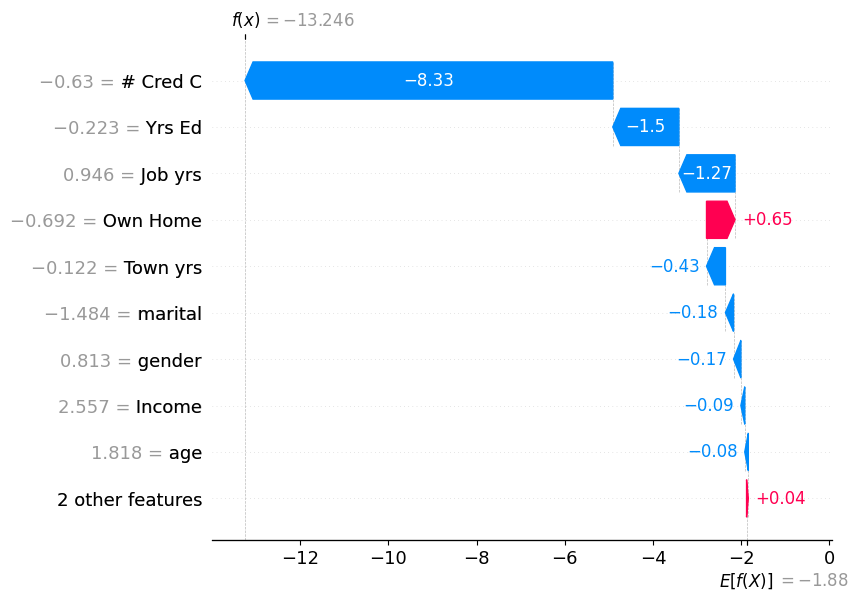

In [35]:
import shap

explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test_df)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

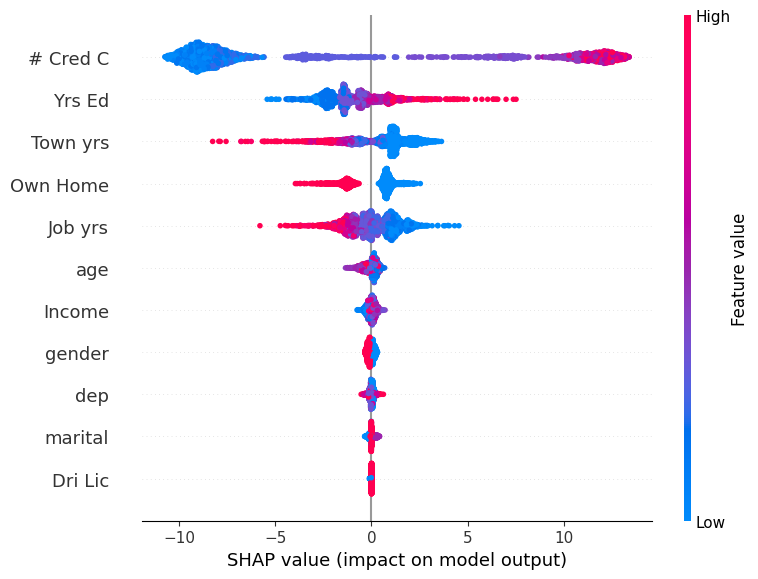

In [34]:
import shap

explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test_df)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, X_test_df)